# Manipulating Real World Data

In [2]:
from pathlib import Path

import torch
import torchvision

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from PIL import Image

In [2]:
data_dir = Path("../dlwpt-code/data")

In [3]:
ch_data_dir = data_dir / "p1ch4"

ch_data_dir.exists()

True

In [19]:
def view_tensor(tensor):
    return tensor.shape, tensor.stride()

## Images

### Single Image

In [39]:
bobby_path = ch_data_dir/"image-dog/bobby.jpg"
bobby_img = Image.open(bobby_path)

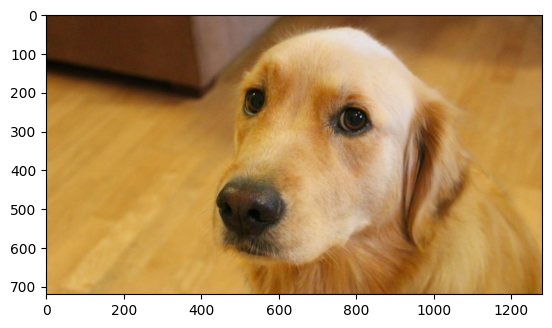

In [193]:
plt.imshow(bobby_img)

In [17]:
bobby_arr = np.array(bobby_img)

In [18]:
bobby_arr.shape

(720, 1280, 3)

$ H\times W\times C$

In [21]:
bobby_tens = torch.from_numpy(bobby_arr)

In [23]:
bobby_out = bobby_tens.permute(2,0,1)

In [24]:
bobby_out.shape

torch.Size([3, 720, 1280])

In [4]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

$ C\times H\times W$

### Batch of images

In [37]:
from torchvision import io

In [25]:
cat_dir = ch_data_dir / "image-cats"

In [44]:
cat_files = [file for file in cat_dir.iterdir() if file.suffix == ".png"]

In [68]:
batch_size = len(cat_images)
cat_batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

In [69]:
for batch_i, cat_file in enumerate(cat_files):
    cat_batch[batch_i] = io.read_image(str(cat_file))
    

In [72]:
cat_batch_fl = cat_batch.float()

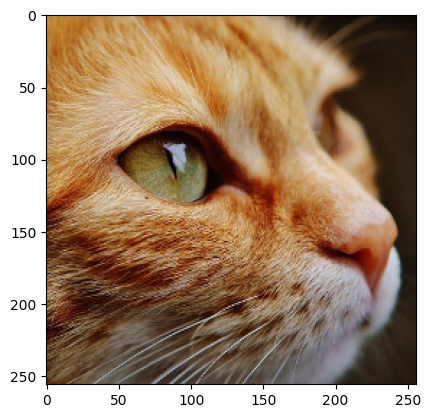

In [77]:
plt.imshow(cat_batch[0].permute(1,2,0))

In [74]:
cat_batch_fl.shape

torch.Size([3, 3, 256, 256])

In [99]:
channel_agg_dims = [0,2,3]

In [100]:
batch_mean = torch.mean(cat_batch_fl, dim=channel_agg_dims).unsqueeze(-1).unsqueeze(-1)

In [101]:
batch_std = torch.std(cat_batch_fl, dim=channel_agg_dims).unsqueeze(-1).unsqueeze(-1)

In [103]:
cat_batch_norm = (cat_batch_fl - batch_mean)/batch_std

## Volumetric Data

In [106]:
import imageio

dir_path = ch_data_dir/"volumetric-dicom/2-LUNG 3.0  B70f-04083"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 39/99  (39.489/99  (89.999/99  (100.0%)


(99, 512, 512)

In [110]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0) # add channel at first dimension, before height

vol.shape

torch.Size([1, 99, 512, 512])

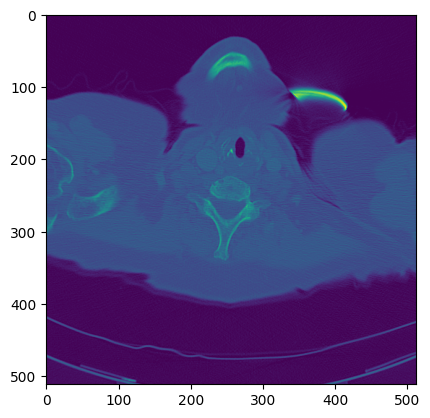

In [111]:
import matplotlib.pyplot as plt

plt.imshow(vol_arr[1])

## Tabular Data

In [126]:
wineq_df = pd.read_csv(ch_data_dir/"tabular-wine/winequality-white.csv", sep=";",dtype=np.float32)

In [128]:
target_name = "quality"

In [129]:
wineq_target = wineq_df.pop(target_name)

In [144]:
wineq_target

0       6.0
1       6.0
2       6.0
3       6.0
4       6.0
       ... 
4893    6.0
4894    5.0
4895    6.0
4896    7.0
4897    6.0
Name: quality, Length: 4898, dtype: float32

In [131]:
wineq_data = torch.from_numpy(wineq_df.values)

In [153]:
wineq_target_tens = torch.from_numpy(wineq_target.values.astype(np.int32))

In [154]:
wineq_target_tens

tensor([6, 6, 6,  ..., 6, 7, 6], dtype=torch.int32)

In [156]:
data_mean = torch.mean(wineq_data, dim=0)
data_mean

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [157]:
data_var = torch.var(wineq_data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

In [158]:
data_normalized = (wineq_data - data_mean) / torch.sqrt(data_var)
data_normalized

tensor([[ 1.7208e-01, -8.1761e-02,  2.1326e-01,  ..., -1.2468e+00,
         -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  4.7997e-02,  ...,  7.3995e-01,
          1.3417e-03, -8.2419e-01],
        [ 1.4756e+00,  1.7450e-02,  5.4378e-01,  ...,  4.7505e-01,
         -4.3677e-01, -3.3663e-01],
        ...,
        [-4.2043e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3130e+00,
         -2.6153e-01, -9.0545e-01],
        [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0049e+00,
         -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7505e-01,
         -1.4882e+00,  1.0448e+00]])

In [161]:
bad_indexes = wineq_target_tens <= 3

bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum()

## Time Series

In [4]:
bikes_df = pd.read_csv(ch_data_dir/"bike-sharing-dataset/hour-fixed.csv", index_col=0)
bikes_df["dteday"] = pd.to_datetime(bikes_df["dteday"])
bikes_df = bikes_df.assign(day = lambda df_: df_["dteday"].dt.day)

In [5]:
bike_cols = list(bikes_df.columns)
bike_cols.insert(0, bike_cols.pop(bike_cols.index("day")))

In [6]:
bikes_df = bikes_df.loc[:,bike_cols]

In [7]:
bikes_df.select_dtypes(np.number)

,day,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2,1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
3,1,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
4,1,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
5,1,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17376,31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17377,31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90


In [8]:
bikes = torch.from_numpy(bikes_df.select_dtypes(np.number).values.astype(np.float32))

In [9]:
bikes

tensor([[ 1.,  1.,  0.,  ...,  3., 13., 16.],
        [ 1.,  1.,  0.,  ...,  8., 32., 40.],
        [ 1.,  1.,  0.,  ...,  5., 27., 32.],
        ...,
        [31.,  1.,  1.,  ...,  7., 83., 90.],
        [31.,  1.,  1.,  ..., 13., 48., 61.],
        [31.,  1.,  1.,  ..., 12., 37., 49.]])

In [10]:
bikes.shape, bikes.stride()

(torch.Size([17520, 16]), (1, 17520))

Hours $\times$ Columns

In [11]:
dims = (
    -1, # Placeholder, remainder of dimensions left given elements
    24, # Hours per day, depends on having all data available and being sorted
    bikes.shape[1] # number of columns
)
bikes_daily = bikes.view(*dims) # reshape without copying data

In [12]:
bikes_daily.shape, bikes_daily.stride()

(torch.Size([730, 24, 16]), (24, 1, 17520))

Days (N) $\times$ Hours (L) $\times$ Columns (C)

In [13]:
bikes_daily = bikes_daily.transpose(1, 2)

In [14]:
bikes_daily.shape, bikes_daily.stride()

(torch.Size([730, 16, 24]), (24, 17520, 1))

### OHE

#### First day example

In [15]:
first_day = bikes_daily[0]

In [27]:
def view_tensor(tensor):
    return tensor.shape, tensor.stride()

In [29]:
weathersit_arr = first_day[8]
view_tensor(weathersit_arr)

(torch.Size([24]), (1,))

In [30]:
weathersit_arr = weathersit_arr.unsqueeze(1).to(torch.int64) - 1
view_tensor(weathersit_arr)

(torch.Size([24, 1]), (1, 1))

In [19]:
torch.unique(weathersit_arr)

tensor([1., 2., 3.])

In [32]:
torch.unique(weathersit_arr)

tensor([0, 1, 2])

In [34]:
weathersit_ohe = torch.zeros(
    weathersit_arr.shape[0], 
    torch.max(weathersit_arr) + 1
)

In [36]:
view_tensor(weathersit_ohe)

(torch.Size([24, 3]), (3, 1))

In [41]:
weathersit_ohe = weathersit_ohe.scatter(
    dim=1,
    index = weathersit_arr,
    value=1
)

In [42]:
weathersit_ohe

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [45]:
view_tensor(bikes)

(torch.Size([17520, 16]), (1, 17520))

In [48]:
view_tensor(first_day)

(torch.Size([16, 24]), (17520, 1))

In [52]:
view_tensor(weathersit_ohe.transpose(0,1))

(torch.Size([3, 24]), (1, 3))

In [49]:
view_tensor(weathersit_ohe)

(torch.Size([24, 3]), (3, 1))

In [55]:
torch.cat((first_day, weathersit_ohe.transpose(0,1)), 0).transpose(0,1)

tensor([[1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         6.0000e+00, 0.0000e+00, 1.0000e+00, 2.4000e-01, 2.8790e-01, 8.1000e-01,
         0.0000e+00, 3.0000e+00, 1.3000e+01, 1.6000e+01, 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
         6.0000e+00, 0.0000e+00, 1.0000e+00, 2.2000e-01, 2.7270e-01, 8.0000e-01,
         0.0000e+00, 8.0000e+00, 3.2000e+01, 4.0000e+01, 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
         6.0000e+00, 0.0000e+00, 1.0000e+00, 2.2000e-01, 2.7270e-01, 8.0000e-01,
         0.0000e+00, 5.0000e+00, 2.7000e+01, 3.2000e+01, 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00,
         6.0000e+00, 0.0000e+00, 1.0000e+00, 2.4000e-01, 2.8790e-01, 7.5000e-01,
         0.0000e+00, 3.0000e+00, 1.0000e+01

#### Full Dataset

In [62]:
ohe_dims = list(bikes_daily.shape)
ohe_dims[1] = 4 # number of ohe colummns (Channels)

daily_weather_onehot = torch.zeros(*ohe_dims)
view_tensor(daily_weather_onehot)

(torch.Size([730, 4, 24]), (96, 24, 1))

In [66]:
daily_weather_onehot = daily_weather_onehot.scatter(
    1,
    (
        bikes_daily[:,8,:]
        .long()
        .unsqueeze(1) 
        - 1
    ),
    1.0
)

In [85]:
daily_bikes = torch.cat(
    (
        bikes_daily,
        daily_weather_onehot
    ),
    dim=1
)

In [86]:
weathersit_arr = daily_bikes[:, 8, :]
weathersit_arr

tensor([[1., 1., 1.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [87]:
min_weathersit = torch.min(weathersit_arr)
max_weathersit = torch.max(weathersit_arr)
mean_weathersit = torch.mean(weathersit_arr)
stdv_weathersit = torch.std(weathersit_arr)

In [91]:
(weathersit_arr - min_weathersit) / (max_weathersit - min_weathersit)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3333, 0.3333, 0.3333,  ..., 0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [93]:
(weathersit_arr - mean_weathersit) / stdv_weathersit

tensor([[-0.6677, -0.6677, -0.6677,  ...,  0.8879,  0.8879,  0.8879],
        [ 0.8879,  0.8879,  0.8879,  ..., -0.6677, -0.6677, -0.6677],
        [-0.6677, -0.6677, -0.6677,  ..., -0.6677, -0.6677, -0.6677],
        ...,
        [ 0.8879,  0.8879,  0.8879,  ...,  0.8879,  0.8879,  0.8879],
        [ 0.8879,  0.8879,  0.8879,  ..., -0.6677, -0.6677, -0.6677],
        [-0.6677, -0.6677, -0.6677,  ..., -0.6677, -0.6677, -0.6677]])

In [78]:
daily_bikes[:, 8, :] = weathersit_scl

## Text

In [115]:
with open(ch_data_dir/"jane-austen/1342-0.txt", encoding="utf8") as f:
    jane_austen = f.read()

In [118]:
jausten_lines = jane_austen.split("\n")

line = jausten_lines[200]

In [119]:
letter_t = torch.zeros(len(line), 128)

In [121]:
view_tensor(letter_t)

(torch.Size([70, 128]), (128, 1))

In [184]:
line

'“Impossible, Mr. Bennet, impossible, when I am not acquainted with him'

In [250]:
%%timeit
letter_t = torch.zeros(len(line), 128)
line_arr = np.array(list(line.encode("ascii", "replace")), dtype=np.uint8)

6.45 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [248]:
line_arr

array([ 63,  73, 109, 112, 111, 115, 115, 105,  98, 108, 101,  44,  32,
        77, 114,  46,  32,  66, 101, 110, 110, 101, 116,  44,  32, 105,
       109, 112, 111, 115, 115, 105,  98, 108, 101,  44,  32, 119, 104,
       101, 110,  32,  73,  32,  97, 109,  32, 110, 111, 116,  32,  97,
        99, 113, 117,  97, 105, 110, 116, 101, 100,  32, 119, 105, 116,
       104,  32, 104, 105, 109], dtype=uint8)

In [245]:
%%timeit
letter_t = torch.zeros(len(line), 128)
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0
    letter_t[i][letter_index] = 1

295 µs ± 8.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [239]:
line_arr.view("|S1")

array([b'?', b'I', b'm', b'p', b'o', b's', b's', b'i', b'b', b'l', b'e',
       b',', b' ', b'M', b'r', b'.', b' ', b'B', b'e', b'n', b'n', b'e',
       b't', b',', b' ', b'i', b'm', b'p', b'o', b's', b's', b'i', b'b',
       b'l', b'e', b',', b' ', b'w', b'h', b'e', b'n', b' ', b'I', b' ',
       b'a', b'm', b' ', b'n', b'o', b't', b' ', b'a', b'c', b'q', b'u',
       b'a', b'i', b'n', b't', b'e', b'd', b' ', b'w', b'i', b't', b'h',
       b' ', b'h', b'i', b'm'], dtype='|S1')

In [240]:
line_arr

array([ 63,  73, 109, 112, 111, 115, 115, 105,  98, 108, 101,  44,  32,
        77, 114,  46,  32,  66, 101, 110, 110, 101, 116,  44,  32, 105,
       109, 112, 111, 115, 115, 105,  98, 108, 101,  44,  32, 119, 104,
       101, 110,  32,  73,  32,  97, 109,  32, 110, 111, 116,  32,  97,
        99, 113, 117,  97, 105, 110, 116, 101, 100,  32, 119, 105, 116,
       104,  32, 104, 105, 109], dtype=uint8)

In [141]:
%%timeit
np.array(tuple(line))

7.87 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [146]:
np.array(line)

array('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
      dtype='<U70')

In [149]:
_146

array('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
      dtype='<U70')

In [151]:
_146.squeeze()

array('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
      dtype='<U70')

In [156]:
_146.ravel().transpose()

array(['“Impossible, Mr. Bennet, impossible, when I am not acquainted with him'],
      dtype='<U70')

In [153]:
_151.stride()

AttributeError: 'numpy.ndarray' object has no attribute 'stride'

In [148]:
_146.shape

()

In [147]:
_146[6]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [144]:
line_arr = np.array(list(line))

In [145]:
line_arr.view(

array(['“', 'I', 'm', 'p', 'o', 's', 's', 'i', 'b', 'l', 'e', ',', ' ',
       'M', 'r', '.', ' ', 'B', 'e', 'n', 'n', 'e', 't', ',', ' ', 'i',
       'm', 'p', 'o', 's', 's', 'i', 'b', 'l', 'e', ',', ' ', 'w', 'h',
       'e', 'n', ' ', 'I', ' ', 'a', 'm', ' ', 'n', 'o', 't', ' ', 'a',
       'c', 'q', 'u', 'a', 'i', 'n', 't', 'e', 'd', ' ', 'w', 'i', 't',
       'h', ' ', 'h', 'i', 'm'], dtype='<U1')

In [143]:
_142

NameError: name '_142' is not defined

In [134]:
np.array(line.split(""))

ValueError: empty separator

In [128]:
line.encode("ascii")

UnicodeEncodeError: 'ascii' codec can't encode character '\u201c' in position 0: ordinal not in range(128)

In [125]:
[
    f"{char}: {ord(str(char, 'ascii'))}" for char in line[:30]
]

TypeError: decoding str is not supported

# Practice

## Load images

In [6]:
practice_data_dir = Path("./data/04")

In [9]:
next(practice_data_dir.iterdir())

PosixPath('data/04/Strawberries.jpg')

In [12]:
_9.stem

'Strawberries'

In [13]:
def directory_of_images_to_tensor(path, valid_fn=None, as_dict=False):
    if not valid_fn:
        valid_fn = lambda x: True
    
    files = [file for file in path.iterdir() if valid_fn(file)]
    images = [torchvision.io.read_image(str(file)) for file in files]
    if as_dict:
        return dict(
            zip(
                [file.stem for file in files], 
                images
            )
        )
    else:
        return images

In [16]:
practice_images = directory_of_images_to_tensor(practice_data_dir, lambda x: x.suffix in (".png", ".jpg"), True)

In [27]:
{
    img_name: view_tensor(tensor)
    for img_name, tensor in practice_images.items()
}

{'leaves': (torch.Size([3, 667, 1000]), (1, 3000, 3)),
 'strawberries': (torch.Size([3, 1796, 2700]), (1, 8100, 3)),
 'apples': (torch.Size([3, 900, 1200]), (1, 3600, 3)),
 'rose': (torch.Size([3, 340, 439]), (1, 1317, 3))}

In [26]:
{
    img_name: torch.mean(tensor.float(), dim=[1,2])
    for img_name, tensor in practice_images.items()
}

{'leaves': tensor([116.9814, 158.1959,  24.8206]),
 'strawberries': tensor([181.6697,  34.3408,  35.8064]),
 'apples': tensor([123.5983, 165.2681,  66.7623]),
 'rose': tensor([54.6995,  7.9927, 10.1463])}